##### Import the Libraries

In [8]:
import cv2
import numpy as np
import time
import keyboard
import pytesseract
from mss import mss
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure

import matplotlib.pyplot as plt
import os

In [9]:
# Create directories if they don't exist
os.makedirs('./ddqn/models', exist_ok=True)
os.makedirs('./ddqn/logs', exist_ok=True)
os.makedirs('./ddqn/tensorboard', exist_ok=True)

### Create an environment

In [10]:
class ChromeDinoEnv(Env):
    def __init__(self):
        super(ChromeDinoEnv, self).__init__()
        
        # Define action space: 0 = do nothing, 1 = jump, 2 = duck
        self.action_space = Discrete(3)
        
        # Define observation space to match _get_observation output
        self.observation_space = Box(low=0, high=255, shape=(83, 100, 1), dtype=np.uint8)
        
        # Screen capture setup
        self.sct = mss()
        self.game_location = {'top': 110, 'left': 50, 'width': 600, 'height': 500}
        self.done_location = {'top': 200, 'left': 600, 'width': 600, 'height': 70}
        
        # Initialize game state
        self.game_over = False
        self.step_count = 0

    def reset(self, **kwargs):
        # Reset the game
        keyboard.press_and_release('space')
        time.sleep(1)
        
        self.game_over = False
        self.step_count = 0
        return self._get_observation(), {}

    def step(self, action):
        # Perform action
        if action == 1:
            keyboard.press_and_release('up')
        elif action == 2:
            keyboard.press_and_release('down')
        
        time.sleep(0.1)
        
        observation = self._get_observation()
        self.game_over, _ = self._check_game_over()
        self.step_count += 1
        
        # Define reward and termination conditions
        reward = 1 if not self.game_over else -10
        done = self.game_over  
        
        return observation, reward, done, False, {}


    def _get_observation(self):
        raw = np.array(self.sct.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        # Return with channels last (height, width, channels)
        return np.expand_dims(resized, axis=-1)
    
    def _check_game_over(self):
        done_cap = np.array(self.sct.grab(self.done_location))
        text = pytesseract.image_to_string(done_cap).lower()
        done = "game over" in text
        return done, done_cap

    def render(self, mode='human'):
        observation = self._get_observation().squeeze()
        observation = (observation * 255).astype(np.uint8)
        cv2.imshow('Game', observation)
        cv2.waitKey(1)

    def close(self):
        cv2.destroyAllWindows()

#### Train the Model

In [11]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True
    
CHECKPOINT_DIR = './ddqn/train/'
LOG_DIR = './ddqn/logs/'
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [12]:
from stable_baselines3.dqn.dqn import DQN
from stable_baselines3.common.utils import get_parameters_by_name
import torch as th
from torch import nn
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values_target = self.q_net_target(replay_data.next_observations)
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network (greedy action selection)
                next_actions_online = next_q_values_online.argmax(dim=1, keepdim=True)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values_target, dim=1, index=next_actions_online)
               
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute Huber loss
            loss = F.smooth_l1_loss(current_q_values, target_q_values)
            
            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))


In [13]:

# Create and wrap the environment
time.sleep(5)  # Give time to focus the game window
env = ChromeDinoEnv()
# Initialize DQN model with more reasonable parameters
model = DoubleDQN(
    "CnnPolicy",
    env,
    verbose=1,
    tensorboard_log=LOG_DIR,
    buffer_size=1200000,
    learning_starts=1000,
)
# Set up and attach custom logger
new_logger = configure(LOG_DIR, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

# Train the model
model.learn(total_timesteps=100000, callback=callback)



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./ddqn/logs/


/Users/alexkagozi/Desktop/AI/ReinforcemnentLearning/chrome-dinosaur/.venv/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 1.41GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.75     |
|    ep_rew_mean      | -2.25    |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 14       |
|    total_timesteps  | 35       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 4.62     |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 42       |
|    total_timesteps  | 125      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes       

### Load and Test the Model

In [14]:
# Load the model
time.sleep(5)  # Give time to focus the game window
env = ChromeDinoEnv()
model = DQN.load('./ddqn/train/best_model_48000', env=env)

for episode in range(5): 
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info, _ = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode + 1, total_reward))
    time.sleep(2)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/alexkagozi/Desktop/AI/ReinforcemnentLearning/chrome-dinosaur/.venv/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 1.86GB
  warnings.warn(


Total Reward for episode 1 is 46
Total Reward for episode 2 is 29
Total Reward for episode 3 is 40
Total Reward for episode 4 is 37
Total Reward for episode 5 is 7


#### Display Metrics

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
logs = pd.read_csv('./ddqn/logs/progress.csv')

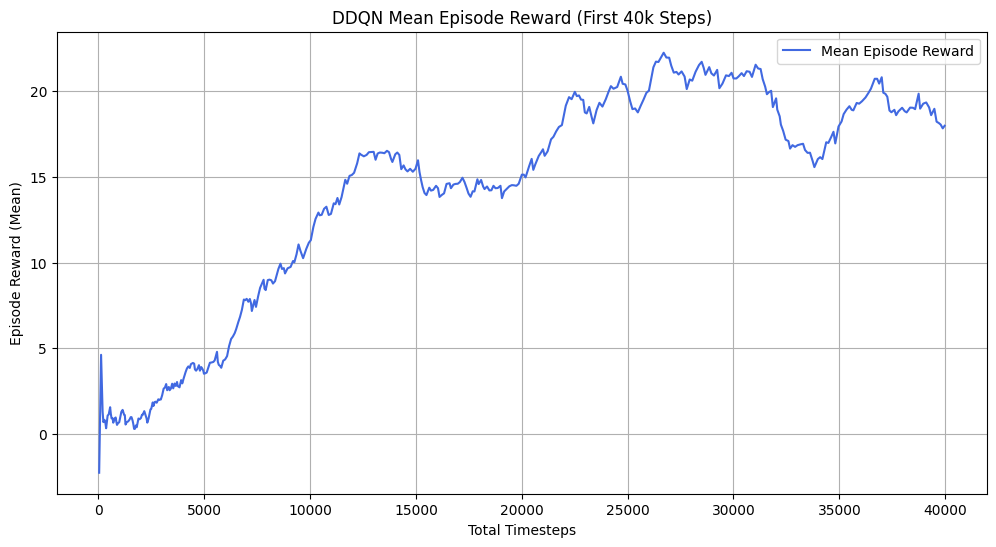

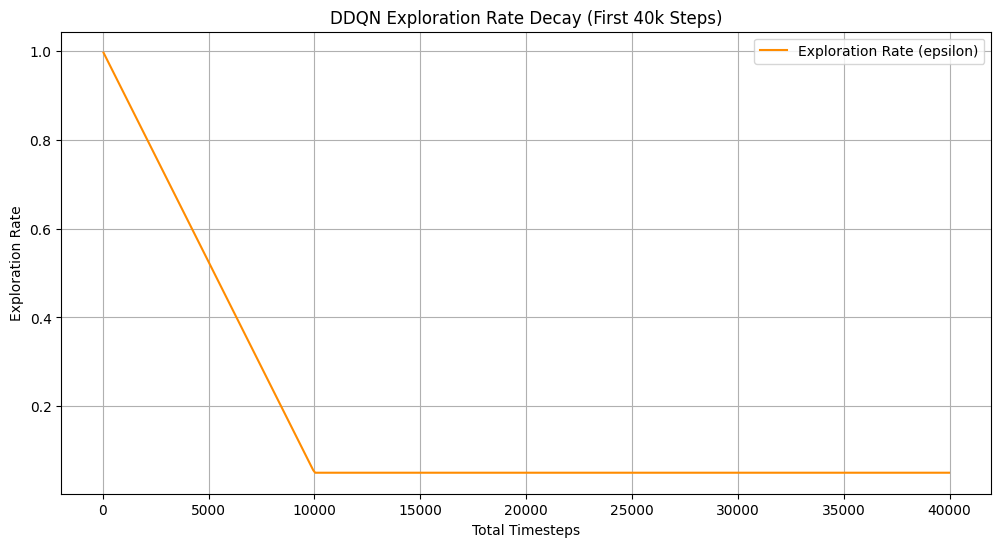

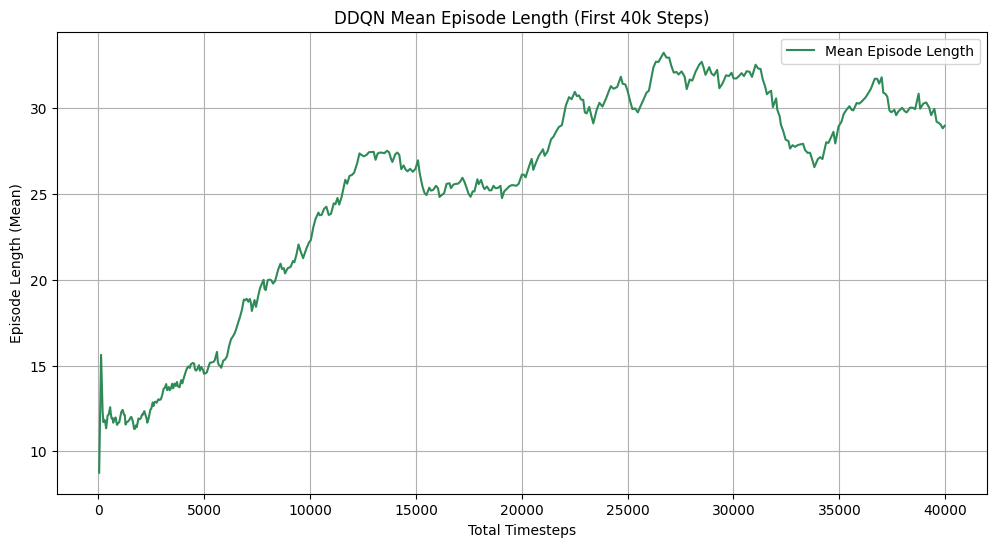

In [16]:


# Filter for first 40,000 timesteps
logs_40k = logs[logs['time/total_timesteps'] <= 40000]
# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_40k['time/total_timesteps'], logs_40k['rollout/ep_rew_mean'], label='Mean Episode Reward', color='royalblue')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('DDQN Mean Episode Reward (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Exploration Rate vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_40k['time/total_timesteps'], logs_40k['rollout/exploration_rate'], label='Exploration Rate (epsilon)', color='darkorange')
plt.xlabel('Total Timesteps')
plt.ylabel('Exploration Rate')
plt.title('DDQN Exploration Rate Decay (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_40k['time/total_timesteps'], logs_40k['rollout/ep_len_mean'], label='Mean Episode Length', color='seagreen')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('DDQN Mean Episode Length (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()


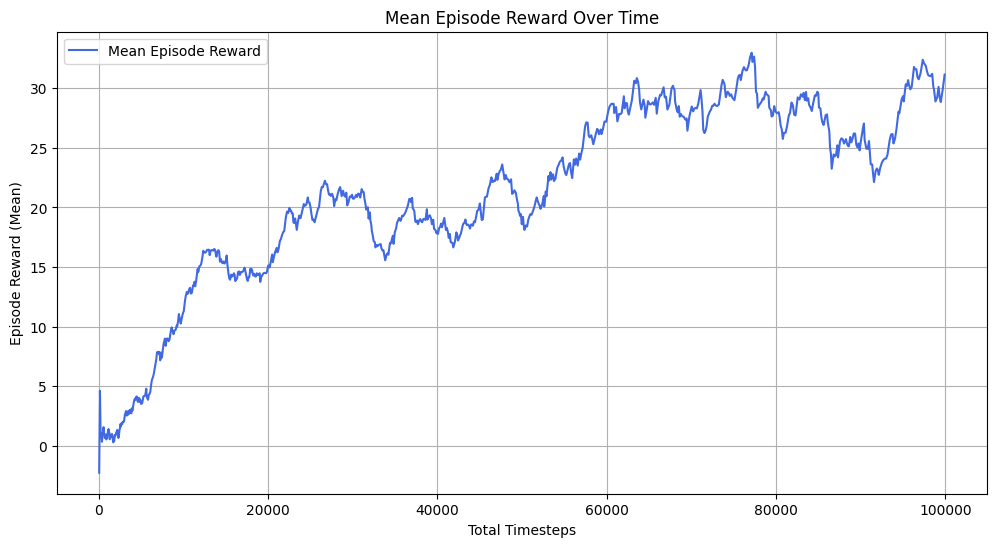

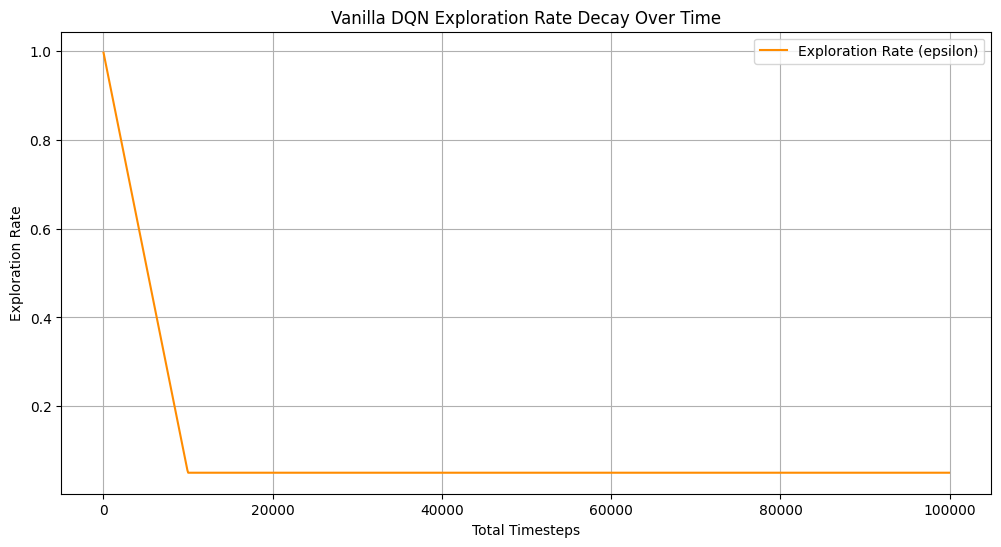

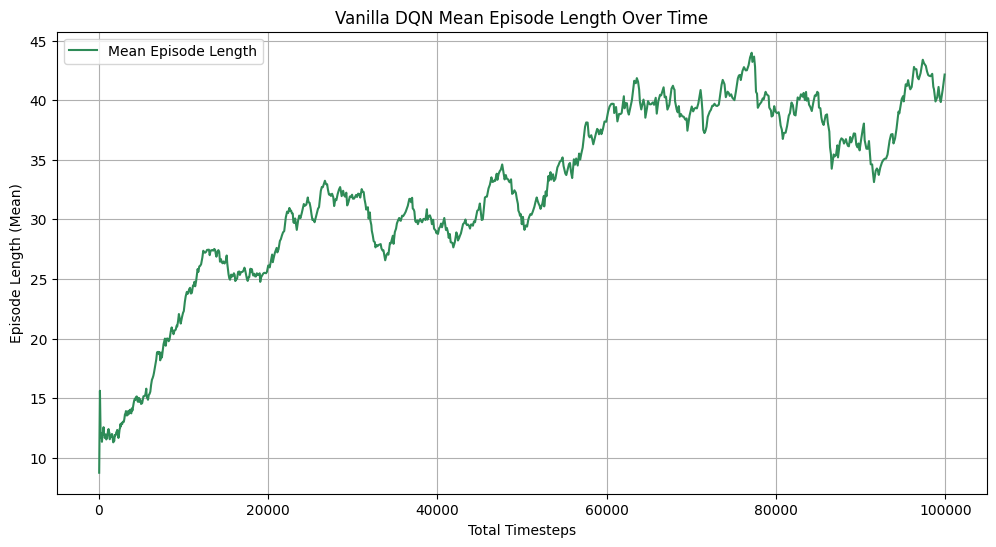

In [17]:
# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_rew_mean'], label='Mean Episode Reward', color='royalblue')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('Mean Episode Reward Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Exploration Rate vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/exploration_rate'], label='Exploration Rate (epsilon)', color='darkorange')
plt.xlabel('Total Timesteps')
plt.ylabel('Exploration Rate')
plt.title('Vanilla DQN Exploration Rate Decay Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_len_mean'], label='Mean Episode Length', color='seagreen')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('Vanilla DQN Mean Episode Length Over Time')
plt.grid(True)
plt.legend()
plt.show()
